### TP 1 : General Observation on Order Book Data

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

In [1]:
# Step 0 : Download of libraries
## allowed libs :  numpy, scipy, pandas, matplotlib, powerlaw, statsmodels,
## tqdm, Hawkes.

import numpy 
import scipy
import pandas as pd 
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
import tqdm   
import Hawkes as hwk

Question 1 : General sanity check and statistical analysis on the dataset

In [2]:
# Step 1: Load all files in the directory
data_path = "Data/SG/"
file_list = [
    "SG_20170117.csv.gz",
    "SG_20170118.csv.gz",
    "SG_20170119.csv.gz",
    "SG_20170120.csv.gz",
    "SG_20170123.csv.gz",
    "SG_20170124.csv.gz",
    "SG_20170125.csv.gz",
    "SG_20170126.csv.gz",
    "SG_20170127.csv.gz",
    "SG_20170130.csv.gz",
    "SG_20170131.csv.gz",
    "SG_20170201.csv.gz",
]
# Create a list to store each DataFrame
df_list = []
for file in file_list:
    df = pd.read_csv(data_path + file, compression='gzip')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df_list.append(df)

# Concatenate all DataFrames into one
filename_df = pd.concat(df_list, ignore_index=True)

In [3]:
# Step 2 : General statistical analysis on the dataset
# 2.1. Check the structure of the data
filename_df.head(10)

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445
5,2017-01-17 09:01:01.110784,C,46005,361,B,46010,1066,46085,1445
6,2017-01-17 09:01:01.140595,A,46010,361,B,46010,1427,46085,1445
7,2017-01-17 09:01:01.142726,M,45905,0,B,46010,1427,46085,1445
8,2017-01-17 09:01:01.143053,C,45960,200,B,46010,1427,46085,1445
9,2017-01-17 09:01:01.143387,C,45965,200,B,46010,1427,46085,1445


In [4]:
# 2.2. Check for missing values
print("DataFrame Info:")
print(filename_df.info())

print("\nMissing values per column:")
print(filename_df.isnull().sum())

# 2.3. Descriptive statistics
print("\nDescriptive Statistics:")
print(filename_df.describe())

# 2.4. Check for duplicates (optional)
duplicates = filename_df.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicates}")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7827010 entries, 0 to 7827009
Data columns (total 9 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ets     datetime64[ns]
 1   etype   object        
 2   eprice  int64         
 3   eqty    int64         
 4   eside   object        
 5   bp0     int64         
 6   bq0     int64         
 7   ap0     int64         
 8   aq0     int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 537.4+ MB
None

Missing values per column:
ets       0
etype     0
eprice    0
eqty      0
eside     0
bp0       0
bq0       0
ap0       0
aq0       0
dtype: int64

Descriptive Statistics:
                                 ets        eprice          eqty  \
count                        7827010  7.827010e+06  7.827010e+06   
mean   2017-01-24 22:36:25.109865984  4.630138e+04  2.330215e+02   
min       2017-01-17 09:01:00.270164  4.600000e+03 -2.217800e+04   
25%    2017-01-19 16:16:42.942011136  4.56

The dataset shows a full day’s worth of trading events with no missing or duplicate rows, which is excellent for high-frequency analysis. Prices range from about 40 000 to 60 760, and best bid/ask prices behave as expected. The only notable anomaly is negative eqty, which indicate cancellations. Otherwise, the data appears reasonably clean and well-structured for deeper market microstructure studies.

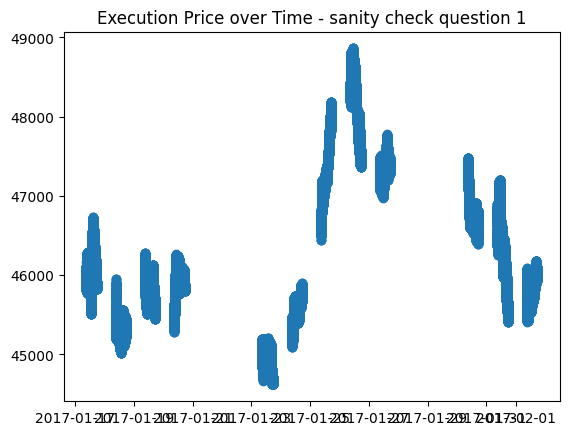

In [5]:
# We are first going to plot the exec price over time
actual_exec_df = filename_df[filename_df['etype'] == 'T']
plt.scatter(actual_exec_df['ets'], actual_exec_df['eprice'], marker='o')
plt.title("Execution Price over Time - sanity check question 1")
plt.show()

Comments : without filtering on actual trades, some exec prices 
are outliers, because they correspond to cancelled orders which had an 
irrealistic price or to modified orders which also had no chance to be 
executed. We confirmed this hypothesis by keeping only the orders that have 
been actually executed, filtering on the "etype", the outliers go away and 
it confirms that the data is clean.

Question 2 : We will plot bid ask mid and compute the observed tick size

In [6]:
## adding for Question 2
filename_df['mid_price'] = (filename_df['bp0'] + filename_df['ap0']) / 2
filename_df['weighted_mid_price'] = (
    filename_df['bp0'] * filename_df['bq0'] + filename_df['ap0'] * filename_df['aq0']
) / (filename_df['bq0'] + filename_df['aq0'])

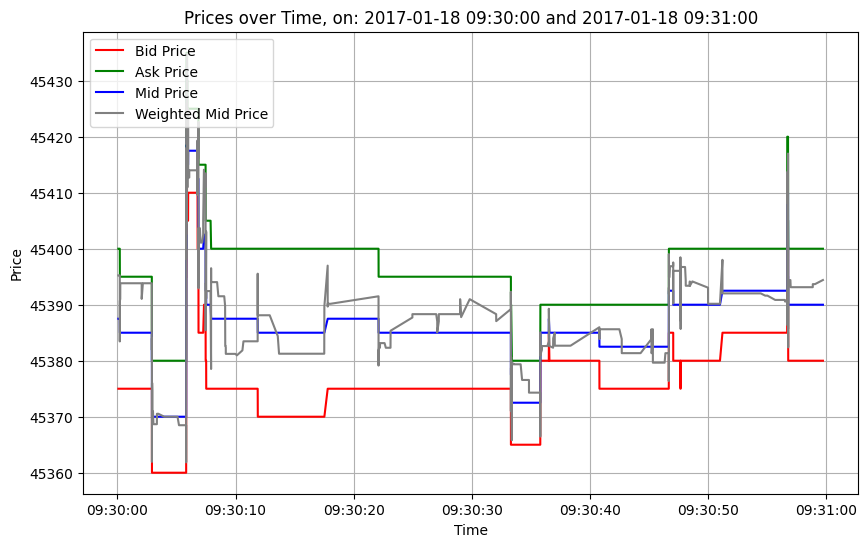

In [7]:
# question 2 : Plot the best bid and ask prices over time, and mid price

#### params ####
start_time = pd.Timestamp("2017-01-18 09:30:00")
end_time = pd.Timestamp("2017-01-18 09:31:00")
################

subset_df = filename_df[(filename_df['ets'] >= start_time) &  
                        (filename_df['ets'] <= end_time)]

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(subset_df['ets'], subset_df['bp0'], color = "r", label="Bid Price")
ax1.plot(subset_df['ets'], subset_df['ap0'], color = "g", label="Ask Price")
ax1.plot(subset_df['ets'], subset_df['mid_price'],  color = "b", label="Mid "
                                                                       "Price")
ax1.plot(subset_df['ets'], subset_df['weighted_mid_price'], color = "gray", 
         label="Weighted Mid Price")

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")

ax1.legend(loc='upper left')
plt.title("Prices over Time, on: " + str(start_time) + " and " +
          str(end_time))
plt.grid(True)
plt.show()

Comments : The plot shows the best bid and ask prices over time, along with the mid price and the weighted mid price. The mid price is the average of the best bid and ask prices, while the weighted mid price is the average of the best bid and ask prices weighted by their respective quantities. The plot shows that the mid price and the weighted mid price are very close, as expected, and that the bid and ask prices are also very close to each other. The plot also shows that the bid and ask prices are very volatile, with frequent changes in direction, while the mid price and the weighted mid price are smoother and more stable. This is because the bid and ask prices are determined by the market participants, while the mid price and the weighted mid price are determined by the market as a whole. The plot also shows that the bid and ask prices are very close to each other, which indicates that the market is very liquid, with a small spread between the bid and ask prices.

Question 3 : Distribution of the order sizes and of the duration of the trades

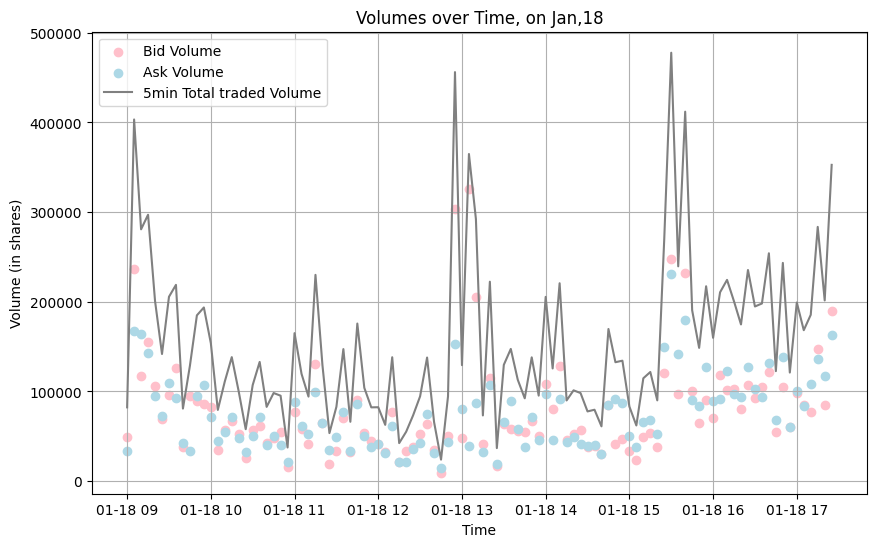

In [8]:
# We shall now analyze the volume profile of the order book on a random day

#### params ####
start_time = pd.Timestamp("2017-01-18 09:00:00")
end_time = pd.Timestamp("2017-01-18 17:30:00")
freq = '5min'
################

subset_df = filename_df[(filename_df['ets'] >= start_time) &  
                        (filename_df['ets'] <= end_time) & 
                        (filename_df['etype'] == 'T')]
subset_df = subset_df.set_index('ets')
subset_df = subset_df[['bq0', 'aq0']].resample(freq).sum()
subset_df['ets'] = subset_df.index

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.scatter(subset_df['ets'], subset_df['bq0'], color = "pink", label="Bid "
                                                                    "Volume")
ax1.scatter(subset_df['ets'], subset_df['aq0'], color = "lightblue", 
            label="Ask Volume")
ax1.plot(subset_df['ets'], subset_df['aq0']+subset_df['bq0'], color = 
"gray", label=freq + " Total traded Volume")

ax1.set_xlabel("Time")
ax1.set_ylabel("Volume (in shares)")

ax1.legend(loc='upper left')
(plt.title("Volumes over Time, on " +  str(start_time.strftime("%b")) +"," +
           str(start_time.day)))
plt.grid(True)
plt.show()


Comments : We see the typical U shape of the volume, with a peak at the 
beginning and at the end of the day. Plus, we see that the volume traded is 
reaching another peak around 13:00, which is a bit uncommon and can be 
related to some news or events that happened during the day.

In [9]:
# Measurement of the tick size
tick_a = filename_df['ap0'].diff().abs().loc[lambda x: x != 0].min()
tick_b = filename_df['bp0'].diff().abs().loc[lambda x: x != 0].min()
tick = min(tick_a, tick_b)
print(f"The (observed) tick size is: {tick}")
## we check that all prices are multiple of the tick size
sanity_check_a = (filename_df['ap0'] % tick).sum()
sanity_check_b = (filename_df['bp0'] % tick).sum()
sanity_check_e = (filename_df['eprice'] % tick).sum()
if sanity_check_a == 0 and sanity_check_b == 0 and sanity_check_e == 0:
    print("All prices are multiples of the tick size")
else:
    print("Not all prices are multiples of the tick size:")
    print(f"Ask prices: {sanity_check_a}")
    print(f"Bid prices: {sanity_check_b}")
    print(f"Exec prices: {sanity_check_e}")

The (observed) tick size is: 5.0
All prices are multiples of the tick size


Comments : The tick size is not be too large in order to allow sufficient 
granularity of prices and not too small in order to limit the competition on 
price priority. Plus, we have checked that, indeed, the prices are multiples
of the tick size.

In [10]:
# Question 3 : Distribution of the order sizes and of the duration of the trades
# 3.1. Order sizes
order_sizes = filename_df[filename_df['etype'] == 'A']['eqty'].abs()

# --- Exponential law for comparison Y-axis ---
n_obs = len(order_sizes)
lamb = 1/order_sizes.mean()
points = numpy.linspace(1, 10000, 2000)
exponential_law = [lamb*numpy.exp(-lamb*x) for x in points]
# --- Power law for comparison Y-axis ---
pl_fit = powerlaw.Fit(order_sizes, discrete=True)  
alpha = pl_fit.alpha
x_min = pl_fit.xmin
points_pl = numpy.logspace(numpy.log10(x_min), numpy.log10(10000), 1000)
C = (alpha - 1) / (x_min ** (alpha - 1))
powerlaw_pdf = C * (points_pl ** (-alpha))

Calculating best minimal value for power law fit


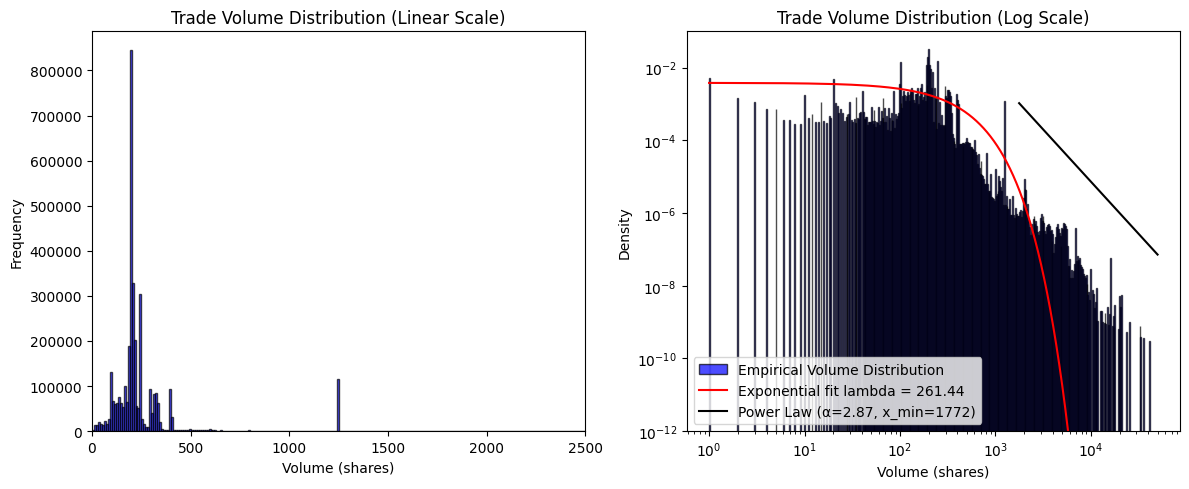

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

min_val = order_sizes.min()
max_val = order_sizes.max()
num_bins = 500  # choose how many bins you want
bins = numpy.logspace(numpy.log10(min_val), numpy.log10(max_val), num_bins)
# --- Left Plot: Linear Scale ---
axes[0].hist(order_sizes, bins=10*num_bins, color='blue', edgecolor='black', 
             alpha=0.7)
axes[0].set_title('Trade Volume Distribution (Linear Scale)')
axes[0].set_xlim(0,2500)
axes[0].set_xlabel('Volume (shares)')
axes[0].set_ylabel('Frequency')
# --- Right Plot: Logarithmic Y-axis ---
axes[1].hist(order_sizes, bins=bins, 
             color='blue', edgecolor='black',
             alpha=0.7, log=True, 
             density=True,  
             label='Empirical Volume Distribution')
axes[1].plot(points,exponential_law, 
             color='red', label='Exponential fit lambda = {:.2f}'.format
    (1/lamb))
pl_fit.power_law.plot_pdf(ax=axes[1], color='black', linestyle='-',
                          label=f'Power Law (α={alpha:.2f}, x_min={x_min:.0f})')

axes[1].set_title('Trade Volume Distribution (Log Scale)')
axes[1].set_xlabel('Volume (shares)')
axes[1].set_ylabel('Density')
axes[1].set_xscale('log')
axes[1].set_ylim(1e-12, 1e-1)
axes[1].legend(loc='lower left')
plt.tight_layout()
plt.show()

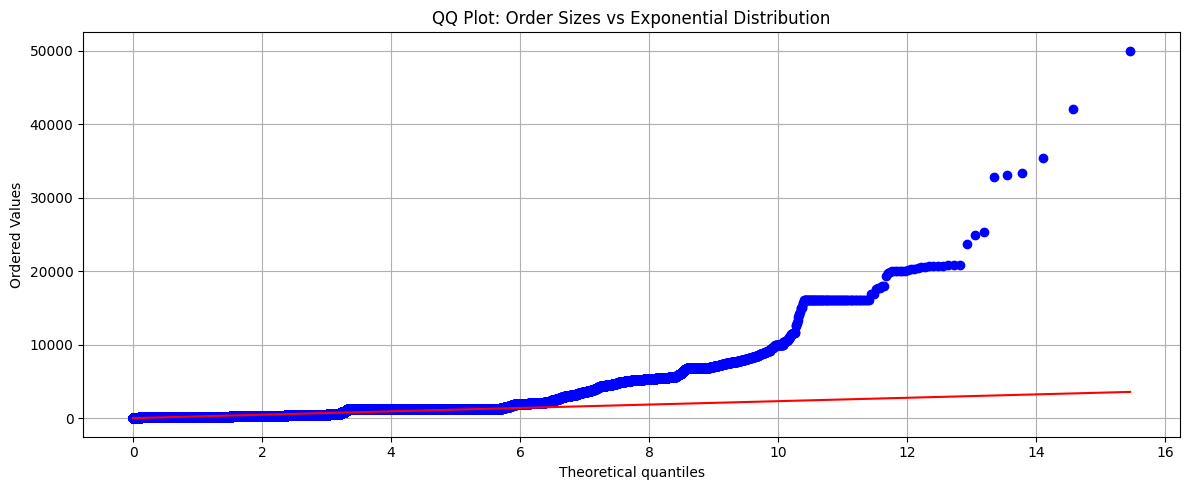

In [17]:
# We create a QQ plot
plt.figure(figsize=(12,5))
scipy.stats.probplot(order_sizes, dist="expon", plot=plt)
plt.title('QQ Plot: Order Sizes vs Exponential Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# 3.2. Duration of the trades
#### params ####
start_time = pd.Timestamp("2017-01-18 08:00:00")
end_time = pd.Timestamp("2017-01-18 18:00:00")
################

actual_exec_df = filename_df[(filename_df['ets'] >= start_time) &  
                        (filename_df['ets'] <= end_time) & 
                        (filename_df['etype'] == 'T')].copy()

actual_exec_df['duration'] = actual_exec_df['ets'].diff().dt.total_seconds()
durations = actual_exec_df['duration'].dropna()
# --- Exponential law for comparison Y-axis ---
n_obs = len(durations)
lamb = 1/durations.mean()
points = numpy.linspace(0, 100, 1000)
exponential_law = [lamb*numpy.exp(-lamb*x) for x in points]

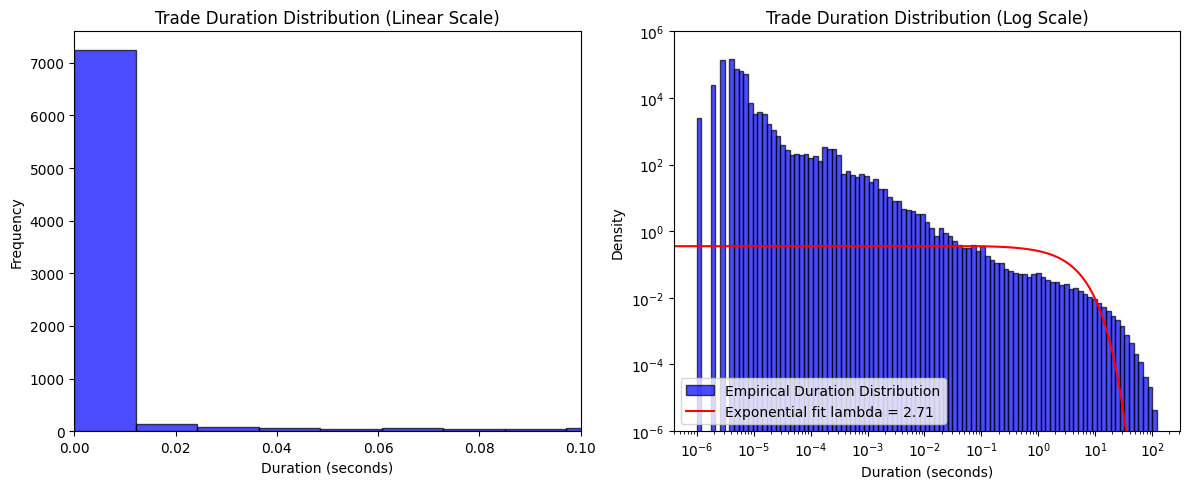

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

min_val = durations.min()
max_val = durations.max()
num_bins = 100  # choose how many bins you want
bins = numpy.logspace(numpy.log10(min_val), numpy.log10(max_val), num_bins)
# --- Left Plot: Linear Scale ---
axes[0].hist(durations, bins=10000, color='blue', edgecolor='black', 
             alpha=0.7)
axes[0].set_title('Trade Duration Distribution (Linear Scale)')
axes[0].set_xlim(0,0.1)
axes[0].set_xlabel('Duration (seconds)')
axes[0].set_ylabel('Frequency')
# --- Right Plot: Logarithmic Y-axis ---
axes[1].hist(durations, bins=bins, 
             color='blue', edgecolor='black',
             alpha=0.7, log=True, 
             density=True,  
             label='Empirical Duration Distribution')
axes[1].plot(points,exponential_law, 
             color='red', label='Exponential fit lambda = {:.2f}'.format
    (1/lamb))

axes[1].set_title('Trade Duration Distribution (Log Scale)')
axes[1].set_xlabel('Duration (seconds)')
axes[1].set_ylabel('Density')
axes[1].set_xscale('log')
axes[1].set_ylim(1e-6, 1e6)
axes[1].legend(loc='lower left')
plt.tight_layout()
plt.show()

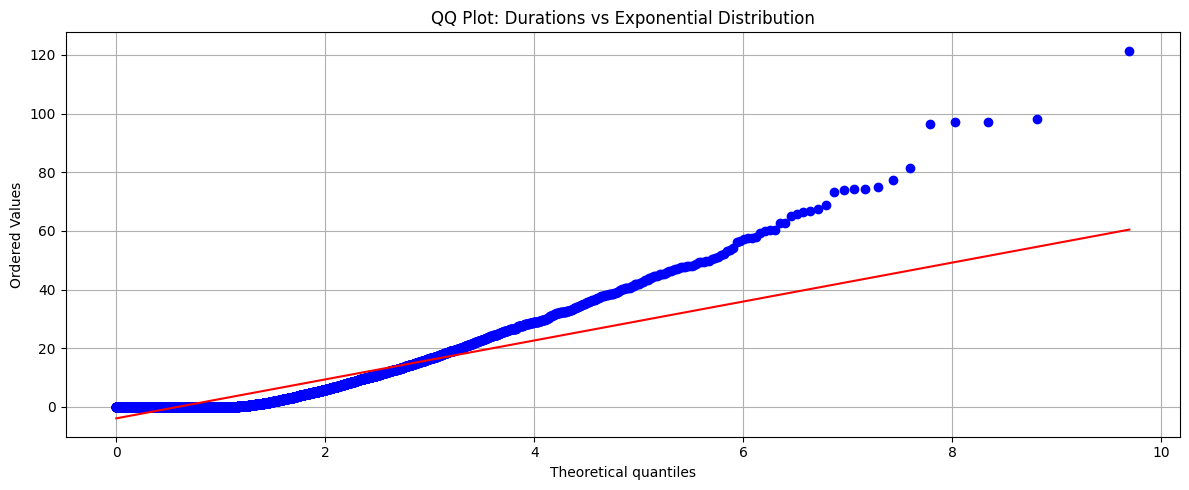

In [16]:
# We create a QQ plot
plt.figure(figsize=(12,5))
scipy.stats.probplot(durations, dist="expon", plot=plt)
plt.title('QQ Plot: Durations vs Exponential Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

Question 4 : Distribution of the spread

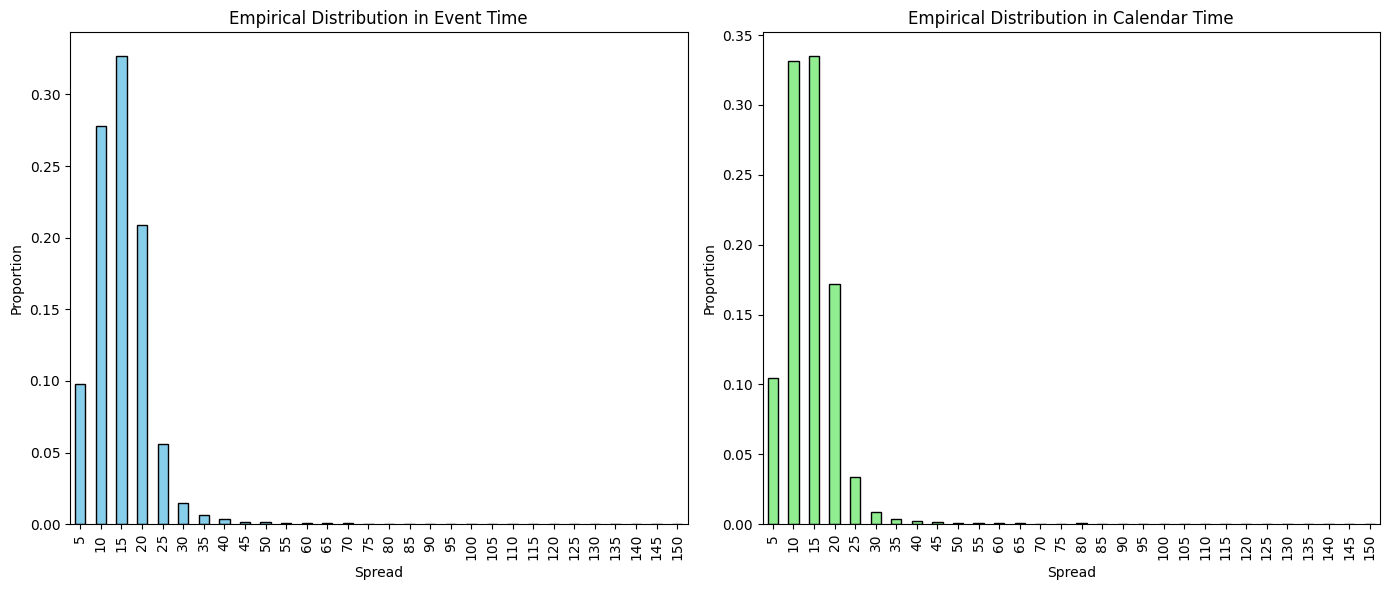

In [22]:
# Question 4
filename_df['spread'] = filename_df['ap0'] - filename_df['bp0']

# Create a DataFrame
df = pd.DataFrame(filename_df)

# Compute the empirical distribution in event time
event_time_distribution = df['spread'].value_counts(normalize=True).sort_index()

# Compute the empirical distribution in calendar time
# Calculate the time intervals
df['interval'] = df['ets'].diff().dt.total_seconds()
df['interval'] = numpy.where(df['interval'] < 30000, df['interval'], numpy.nan)

# Sum of weights
total_weight = df['interval'].sum()

# Calculate the weighted distribution
calendar_time_distribution = (df.groupby('spread')['interval'].sum() / total_weight).sort_index()

# Display the results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Event Time Distribution Plot
event_time_distribution.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('Empirical Distribution in Event Time')
ax[0].set_xlabel('Spread')
ax[0].set_ylabel('Proportion')

# Calendar Time Distribution Plot
calendar_time_distribution.plot(kind='bar', ax=ax[1], color='lightgreen', edgecolor='black')
ax[1].set_title('Empirical Distribution in Calendar Time')
ax[1].set_xlabel('Spread')
ax[1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

Question 5 : Distribution of the log returns on different sampling frequencies

In [23]:
# Question 5
df_q5 = filename_df.copy()
df_q5

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,mid_price,weighted_mid_price,spread
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445,46047.5,46053.160096,75
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445,46047.5,46053.160096,75
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445,46047.5,46053.160096,75
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445,46047.5,46053.160096,75
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445,46047.5,46053.160096,75
...,...,...,...,...,...,...,...,...,...,...,...,...
7827005,2017-02-01 17:29:59.286593,M,46005,0,B,46005,552,46030,640,46017.5,46018.422819,25
7827006,2017-02-01 17:29:59.287101,C,46030,230,S,46005,552,46030,410,46017.5,46015.654886,25
7827007,2017-02-01 17:29:59.529079,A,46055,167,S,46005,552,46030,410,46017.5,46015.654886,25
7827008,2017-02-01 17:29:59.543106,M,45085,0,B,46005,412,46030,410,46017.5,46017.469586,25


In [24]:
# Compute the log returns for a given sampling frequency
def compute_log_returns(df, freq):
    processing_df = df[df['etype'] == 'T'].copy()
    processing_df = processing_df.set_index('ets')
    processing_df = processing_df['eprice'].resample(freq).last()
    log_returns = numpy.log(processing_df/processing_df.shift(1))
    log_returns.rename('log_returns', inplace=True)
    log_returns.dropna(inplace=True)
    return log_returns

Normality test statistic: 84.49417650306393
p-value: 4.490789472465283e-19
We reject the gaussian hypothesis

Jarque-Bera statistic: 289.23946296471746
p-value: 1.5575738343937855e-63
Jarque-Bera test shows that fat tails appear in this case


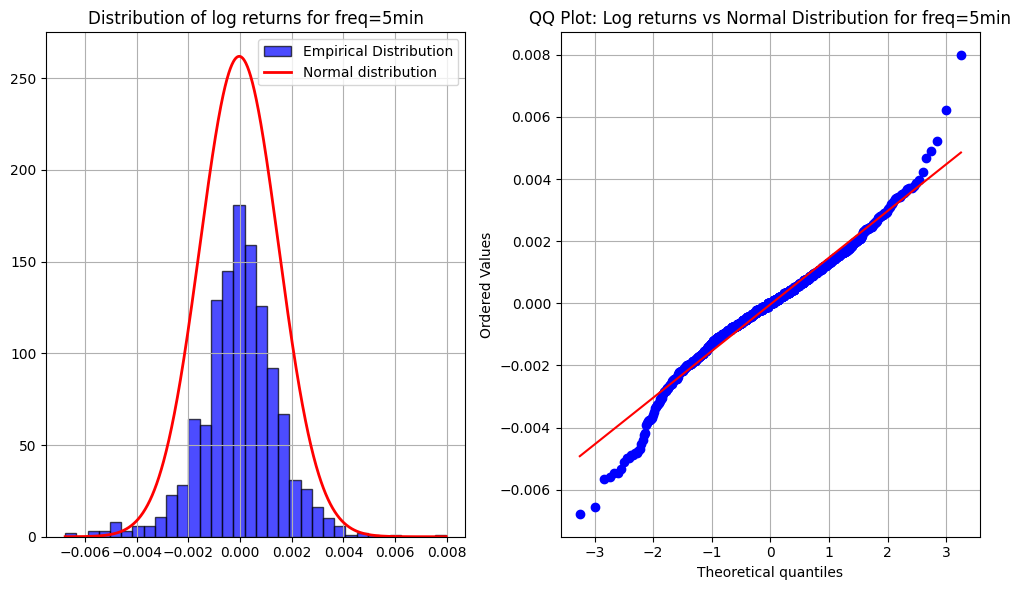

In [25]:
# Testing if the log returns are gaussian for an exemple
# --- params --- #
freq = '5min'
##################
log_returns = compute_log_returns(df_q5, freq)

# Statistical test for normality and fat tails / kurtosis: D'Agostino-Pearson 
# and Jarque-Bera tests
stat, p_value = scipy.stats.normaltest(log_returns)
print("Normality test statistic:", stat)
print("p-value:", p_value)
if p_value > 0.05:
    print("Cannot reject the gaussian hypothesis\n")
if p_value < 0.05:
    print("We reject the gaussian hypothesis\n")
jb_stat, jb_p = scipy.stats.jarque_bera(log_returns)
print("Jarque-Bera statistic:", jb_stat)
print("p-value:", jb_p)
if jb_p < 0.05:
    print("Jarque-Bera test shows that fat tails appear in this case")
if jb_p > 0.05:
    print("Jarque-Bera test cannot say that fat tails appear in this case")

# --- Gaussian law for comparison ---
mu = log_returns.mean()
sigma = log_returns.std()
x = numpy.linspace(log_returns.min(), log_returns.max(), 1000)
pdf = scipy.stats.norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(log_returns, bins=int(numpy.sqrt(len(log_returns))), color='blue', 
        edgecolor='black', 
             alpha=0.7, label='Empirical Distribution', density=False)
ax[0].plot(x, pdf, 'r-', lw=2, label='Normal distribution')
ax[0].legend()
ax[0].grid(True)
ax[0].set_title('Distribution of log returns for freq=' + freq)
# Right subplot: QQ plot
scipy.stats.probplot(log_returns, dist="norm", plot=ax[1])
ax[1].set_title('QQ Plot: Log returns vs Normal Distribution for freq=' + freq)
ax[1].grid(True)

plt.tight_layout()
plt.show()

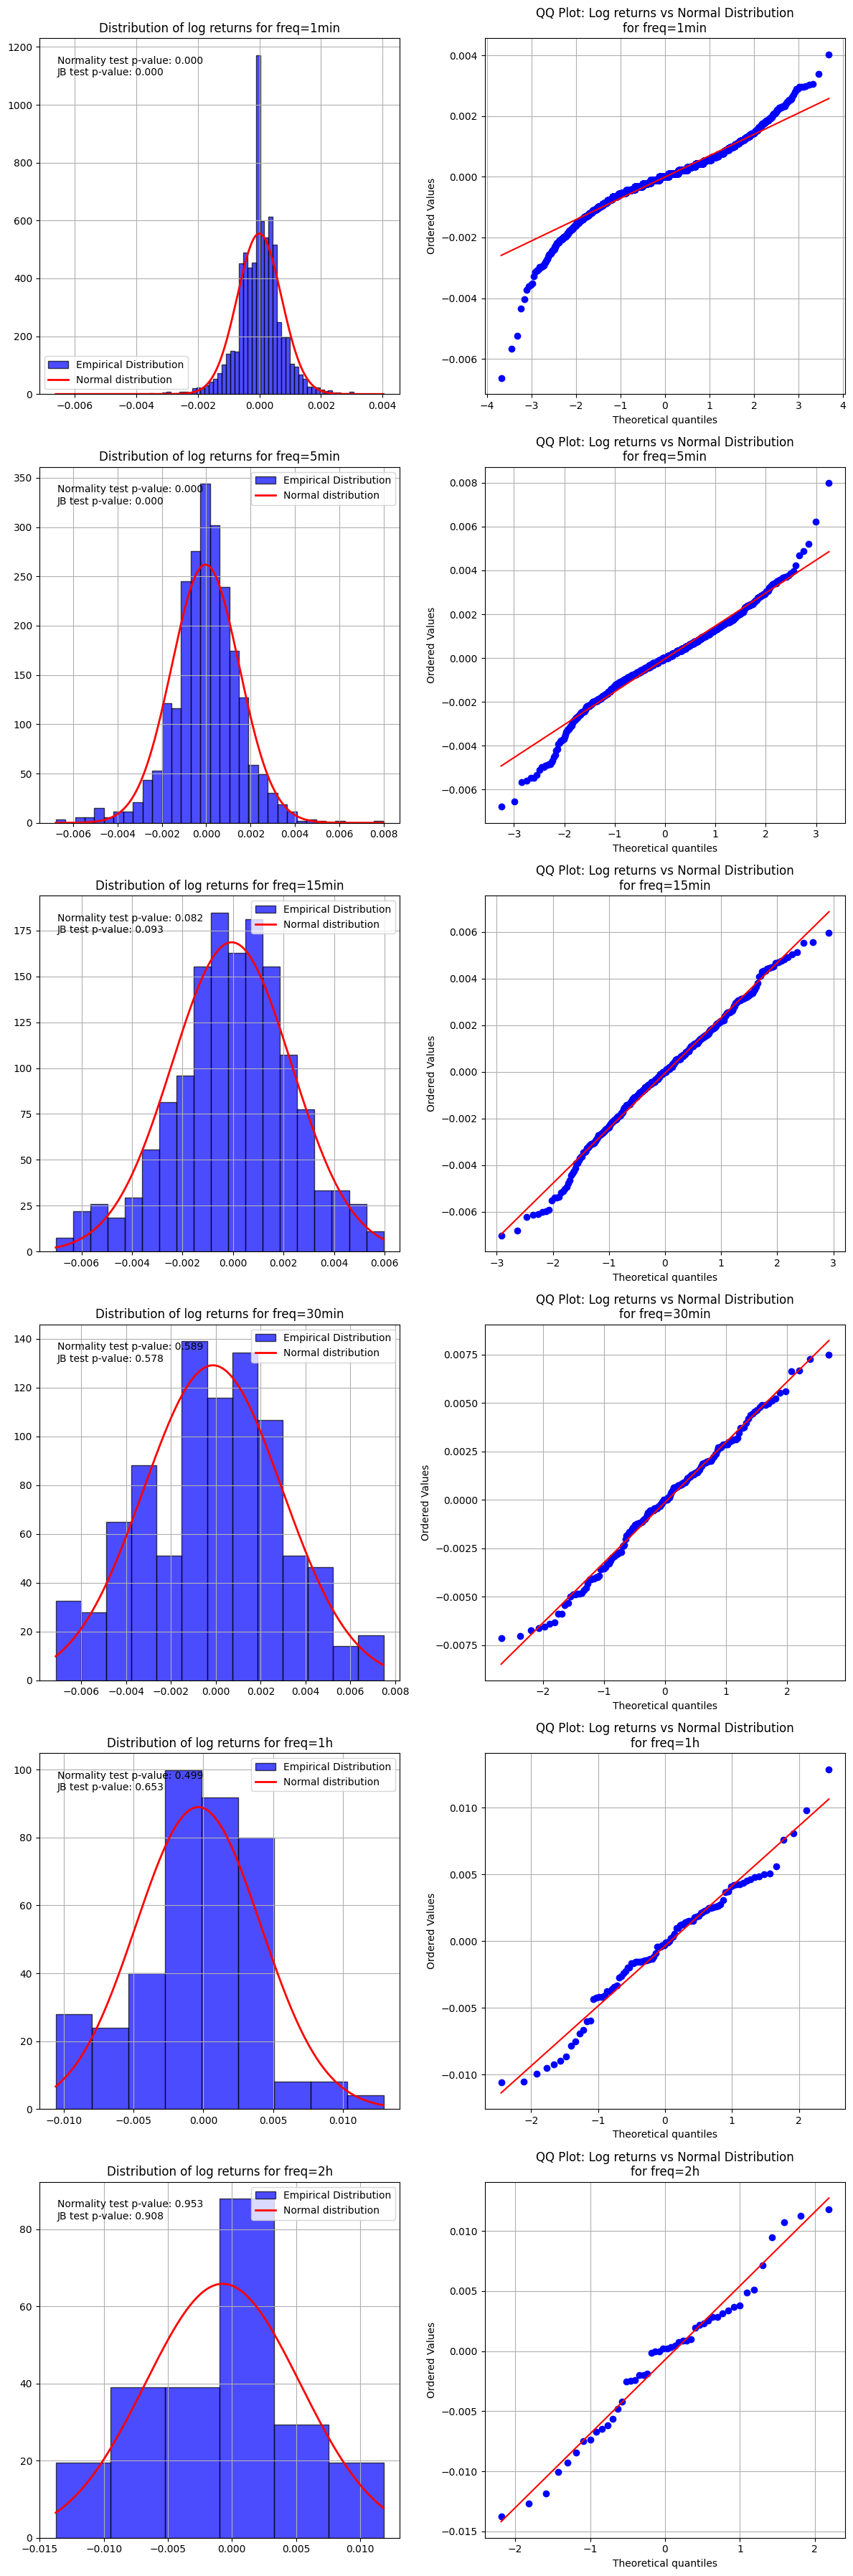

In [26]:
## we now generalize this exemple to several frequencies
# List of frequency strings you want to analyze
freqs = ["1min",'5min', '15min', "30min", '1h',"2h"]

fig, ax = plt.subplots(len(freqs), 2, figsize=(12, 6 * len(freqs)))
if len(freqs) == 1:
    ax = numpy.array([ax])
    
#copy paste of before + adding the tests inside the plots
for i, freq in enumerate(freqs):
    log_returns = compute_log_returns(df_q5, freq)
    #  Tests
    stat, p_value = scipy.stats.normaltest(log_returns)  
    jb_stat, jb_p = scipy.stats.jarque_bera(log_returns)

    # Gaussian  
    mu = log_returns.mean()
    sigma = log_returns.std()
    x = numpy.linspace(log_returns.min(), log_returns.max(), 1000)
    pdf = scipy.stats.norm.pdf(x, mu, sigma)
    
    # Left subplot: Histogram 
    ax[i, 0].hist(log_returns, bins=int(numpy.sqrt(len(log_returns))),
                  color='blue', edgecolor='black', alpha=0.7,
                  density=True, label='Empirical Distribution')
    ax[i, 0].plot(x, pdf, 'r-', lw=2, label='Normal distribution')
    ax[i, 0].legend()
    ax[i, 0].grid(True)
    ax[i, 0].set_title(f'Distribution of log returns for freq={freq}')
    ax[i, 0].text(0.05, 0.95,
    f"Normality test p-value: {p_value:.3f}\nJB test p-value: "f"{jb_p:.3f}",
    transform=ax[i, 0].transAxes, verticalalignment='top')
    
    # Right subplot: QQ Plot
    scipy.stats.probplot(log_returns, dist="norm", plot=ax[i, 1])
    ax[i, 1].set_title(f'QQ Plot: Log returns vs Normal Distribution\nfor '
                        f'freq={freq}')
    ax[i, 1].grid(True)

plt.tight_layout()
plt.show()

Question 6 : Study of the imbalance and its prediction properties

In [148]:
# Question 6
df_q6 = filename_df.copy()
df_q6 = df_q6[df_q6['etype'].isin(['T'])]
df_q6['imbalance'] = (df_q6['bq0'] - df_q6['aq0']) / (df_q6['aq0'] + 
                                                      df_q6['bq0'])
print(df_q6.loc[df_q6['eqty']<0])

Empty DataFrame
Columns: [ets, etype, eprice, eqty, eside, bp0, bq0, ap0, aq0, mid_price, weighted_mid_price, spread, imbalance]
Index: []


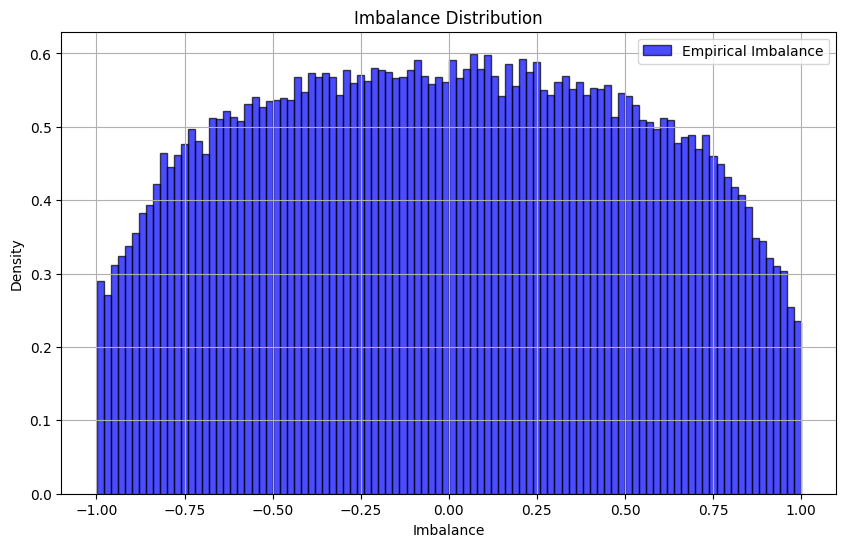

In [139]:
# vizualisation of the imbalance
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_q6['imbalance'], bins=100, color='blue', 
                            edgecolor='black', alpha=0.7, density=True, 
                            label='Empirical Imbalance')

plt.title('Imbalance Distribution')
plt.xlabel('Imbalance')
plt.ylabel('Density')
plt.legend()
plt.grid(True)  
plt.show()

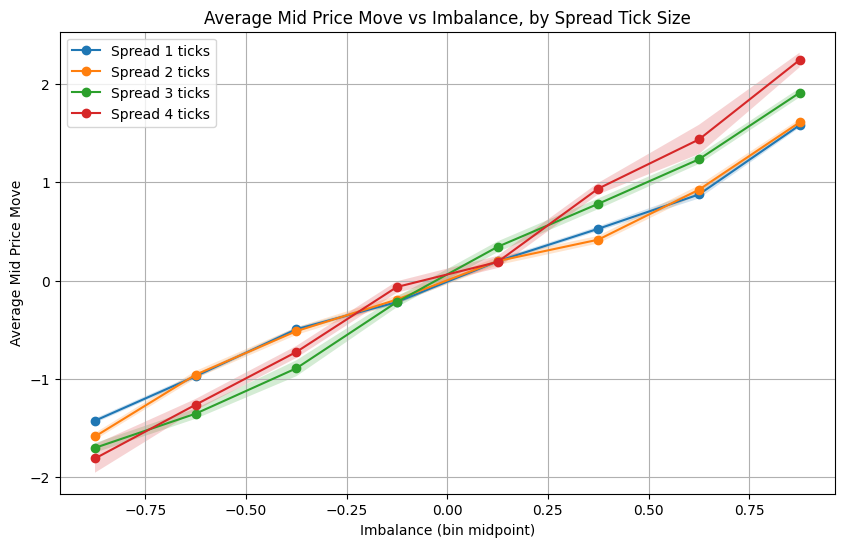

In [153]:
bins = numpy.arange(-1.0,1.01, 0.25)  
df_q6['imbalance_group'] = pd.cut(df_q6['imbalance'], bins=bins)
df_q6['spread_tick_size'] = df_q6['spread'] // 5
df_q6['mid_price_move'] = df_q6['mid_price'].diff().shift(-1)

average_mid_price_move = (
    df_q6.groupby(['imbalance_group', 
                                             'spread_tick_size'], observed=False)
    ['mid_price_move'].mean())
std_mid_price_move = (
    df_q6.groupby(['imbalance_group', 
'spread_tick_size'], observed=False)
    ['mid_price_move'].std()
)

df_pivot_mean = average_mid_price_move.unstack('spread_tick_size')
df_pivot_std  = std_mid_price_move.unstack('spread_tick_size')

plt.figure(figsize=(10, 6))

spreads_to_plot = [1, 2, 3, 4]

for spread in spreads_to_plot:
    mean_series = df_pivot_mean[spread].dropna()
    std_series  = df_pivot_std[spread].dropna()

    x_values = [interval.mid for interval in mean_series.index]
    y_values = mean_series.values
    y_errors = std_series.values

    plt.plot(x_values, y_values, marker='o', label=f"Spread {spread} ticks")
    plt.fill_between(x_values,
                     y_values - 0.01*y_errors,
                     y_values + 0.01*y_errors,
                     alpha=0.2)

plt.title('Average Mid Price Move vs Imbalance, by Spread Tick Size')
plt.xlabel('Imbalance (bin midpoint)')
plt.ylabel('Average Mid Price Move')
plt.grid(True)
plt.legend()
plt.show()